In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
#np.random.seed(1337)  # for reproducibility

from sklearn.datasets import make_swiss_roll

from theano import function

from keras.datasets import mnist
from keras.models import Sequential
from numpy.random import normal
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Layer
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from seya.layers.variational import VariationalDense as VAE
from seya.layers.convolutional import GlobalPooling2D
from seya.utils import apply_model
from seya.layers.regularization import ITLRegularizer
from seya.parzen import ParzenWindows

from agnez import grid2d, embedding2dplot
import math

Using Theano backend.


In [2]:
code_size = 2
# input image dimensions
img_rows, img_cols = 28, 28
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype("float32").reshape((-1, 784))
X_test = X_test.astype("float32").reshape((-1, 784))
X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_valid = X_train[50000:]
Y_valid = Y_train[50000:]
X_train = X_train[:50000]
Y_train = Y_train[:50000]

X_train shape: (60000, 784)
60000 train samples
10000 test samples


In [3]:
#add mix_Gaussian source noise
noise_v1 = 1
noise_v2 = 10
A = .5
noise_factor = 0.01
source_noise_train = (1-A) * normal(0, np.sqrt(noise_v1), X_train.shape) + A * normal(0, np.sqrt(noise_v2), X_train.shape)
source_noise_valid = (1-A) * normal(0, np.sqrt(noise_v1), X_valid.shape) + A * normal(0, np.sqrt(noise_v2), X_valid.shape)
source_noise_test = (1-A) * normal(0, np.sqrt(noise_v1), X_test.shape) + A * normal(0, np.sqrt(noise_v2), X_test.shape)
x_train_noisy = X_train + noise_factor*source_noise_train
x_valid_noisy = X_valid + noise_factor*source_noise_valid
x_test_noisy = X_test + noise_factor*source_noise_test

In [4]:
# ten Gaussian prior distribution
# size is the number of samples for each Gaussian
# scalar can change the distance between the Gaussian
mix_gaussian_scalar = 2.5
def gaussian_mixture_10(size, scalar=mix_gaussian_scalar):

    size = 500

    mean1 = [4.*scalar, 0.*scalar]
    mean2 = [3.24*scalar, 2.35*scalar]
    mean3 = [1.24*scalar, 3.80*scalar]
    mean4 = [-1.24*scalar, 3.80*scalar]
    mean5 = [-3.24*scalar, 2.35*scalar]
    mean6 = [-4.*scalar, 0.*scalar]
    mean7 = [-3.24*scalar, -2.35*scalar]
    mean8 = [-1.24*scalar, -3.80*scalar]
    mean9 = [1.24*scalar, -3.80*scalar]
    mean10 = [3.24*scalar, -2.35*scalar]

    cov1 = [[10., 0.], [0., 1.]]
    cov2 = [[6.89, 4.28], [4.28, 4.11]]
    cov3 = [[1.86, 2.65], [2.65, 9.14]]
    cov4 = [[1.86, -2.65], [-2.65, 9.14]]
    cov5 = [[6.89, -4.28], [-4.28, 4.11]]
    cov6 = [[10., 0.], [0., 1.]]
    cov7 = [[6.89, 4.28], [4.28, 4.11]]
    cov8 = [[1.86, 2.65], [2.65, 9.14]]
    cov9 = [[1.86, -2.65], [-2.65, 9.14]]
    cov10 = [[6.89, -4.28], [-4.28, 4.11]]

    X1 = np.random.multivariate_normal(mean1, cov1, size)
    X2 = np.random.multivariate_normal(mean2, cov2, size)
    X3 = np.random.multivariate_normal(mean3, cov3, size)
    X4 = np.random.multivariate_normal(mean4, cov4, size)
    X5 = np.random.multivariate_normal(mean5, cov5, size)
    X6 = np.random.multivariate_normal(mean6, cov6, size)
    X7 = np.random.multivariate_normal(mean7, cov7, size)
    X8 = np.random.multivariate_normal(mean8, cov8, size)
    X9 = np.random.multivariate_normal(mean9, cov9, size)
    X10 = np.random.multivariate_normal(mean10, cov10, size)

    X = K.concatenate([X1, X2, X3, X4, X5, X6, X7, X8, X9, X10], axis=0)
    return X

#add channel noise
def my_awgn(sig,SNR):
    sigPower= sum(sum(abs(sig)**2))/(sig.shape[0]*sig.shape[1])
    sigPower = 10*math.log10(sigPower)
    noisePower = sigPower - SNR
    p = 10**(noisePower/10)
    noise = (np.sqrt(p))*np.random.randn(sig.shape[0],sig.shape[1])
    noise_sig = sig + noise
    return noise_sig

In [9]:
#Principle of relevant information(pri)
pri_lambda = 5 
pri_scale = 1
pri_ksize = 6.

#encoder architecture
enc = Sequential()
enc.add(Dense(1000, input_dim=784, activation='relu'))
enc.add(BN())
enc.add(Dense(1000, activation='relu'))
enc.add(BN())
enc.add(Dense(2))
enc.add(ITLRegularizer(distance='pri', scale=pri_scale, ksize=pri_ksize, pri_lambda=pri_lambda,
                       distribution=gaussian_mixture_10                
                     ))

#decoder architecture
dec = Sequential()
dec.add(Dense(1000, input_dim=2, activation='relu'))
dec.add(Dense(784, activation='sigmoid'))

In [12]:
#compile the model and using c-loss cost funciton
closs_ksize = 4.0
model = Sequential(ksize = closs_ksize)
model.add(enc)
model.add(dec)
model.compile(loss='c_loss', optimizer='adam')
model.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 784)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Sequential (Unnamed)          (None, 2)                     1792002             
Sequential (Unnamed)          (None, 784)                   787784              
--------------------------------------------------------------------------------
Total params: 2579786
--------------------------------------------------------------------------------


In [41]:
#cbk = ModelCheckpoint('./gussian10_model/itl_mnist_noise_gaussian10_c_loss_A_0.9.hdf5', save_best_only=True, verbose=True)

#model.fit(x_train_noisy, X_train.reshape((-1, 784)), batch_size=1000, nb_epoch=100, verbose=2,
#      validation_data=(x_valid_noisy, X_valid.reshape((-1, 784))),
#      callbacks=[cbk]
#    )

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.06341, saving model to ./gussian10_model/itl_mnist_noise_gaussian10_c_loss_A_0.9.hdf5
44s - loss: 6.5324 - val_loss: 0.0634
Epoch 2/100
Epoch 00001: val_loss improved from 0.06341 to 0.06160, saving model to ./gussian10_model/itl_mnist_noise_gaussian10_c_loss_A_0.9.hdf5
37s - loss: 5.6641 - val_loss: 0.0616
Epoch 3/100
Epoch 00002: val_loss improved from 0.06160 to 0.05988, saving model to ./gussian10_model/itl_mnist_noise_gaussian10_c_loss_A_0.9.hdf5
36s - loss: 5.5852 - val_loss: 0.0599
Epoch 4/100
Epoch 00003: val_loss improved from 0.05988 to 0.05940, saving model to ./gussian10_model/itl_mnist_noise_gaussian10_c_loss_A_0.9.hdf5
37s - loss: 5.5042 - val_loss: 0.0594
Epoch 5/100
Epoch 00004: val_loss improved from 0.05940 to 0.05849, saving model to ./gussian10_model/itl_mnist_noise_gaussian10_c_loss_A_0.9.hdf5
36s - loss: 5.4047 - val_loss: 0.0585
Epoch 6/100
Epoch 00005: val_

Epoch 00063: val_loss did not improve
43s - loss: 5.0836 - val_loss: 0.0519
Epoch 65/100
Epoch 00064: val_loss did not improve
43s - loss: 5.0817 - val_loss: 0.0515
Epoch 66/100
Epoch 00065: val_loss did not improve
43s - loss: 5.0823 - val_loss: 0.0513
Epoch 67/100
Epoch 00066: val_loss did not improve
44s - loss: 5.0799 - val_loss: 0.0517
Epoch 68/100
Epoch 00067: val_loss did not improve
43s - loss: 5.0830 - val_loss: 0.0514
Epoch 69/100
Epoch 00068: val_loss did not improve
43s - loss: 5.0831 - val_loss: 0.0514
Epoch 70/100
Epoch 00069: val_loss improved from 0.05125 to 0.05122, saving model to ./gussian10_model/itl_mnist_noise_gaussian10_c_loss_A_0.9.hdf5
43s - loss: 5.0823 - val_loss: 0.0512
Epoch 71/100
Epoch 00070: val_loss did not improve
43s - loss: 5.0814 - val_loss: 0.0514
Epoch 72/100
Epoch 00071: val_loss did not improve
44s - loss: 5.0815 - val_loss: 0.0513
Epoch 73/100
Epoch 00072: val_loss did not improve
43s - loss: 5.0780 - val_loss: 0.0513
Epoch 74/100
Epoch 00073: 

In [13]:
#load the best model
model.load_weights('./gussian10_model/itl_mnist_noise_gaussian10_c_loss_A_0.5.hdf5')

In [15]:
#build the encoder and decoder funciton to show the 
#result of the hidd
X = K.placeholder(ndim=2)
Y = dec(X)
F_dec = function([X], Y, allow_input_downcast=True)
X = K.placeholder(ndim=2)
Y = enc(X)
F_enc = function([X], Y, allow_input_downcast=True)

Text(0.5, 1.0, 'channel_noise = 14dB')

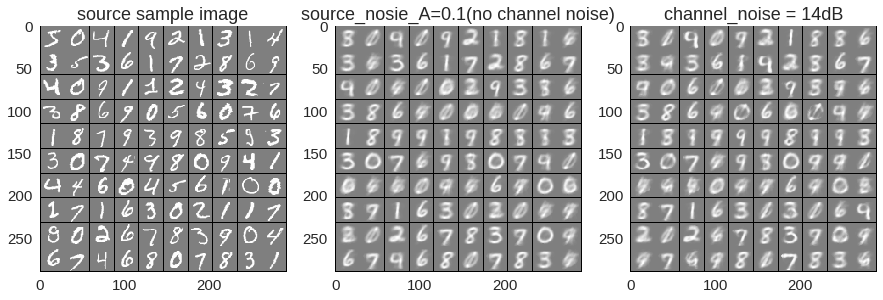

In [65]:
#use source noise as input
y = F_enc(x_train_noisy[:100])
#add channel noise
y_noisy = my_awgn(y,8)
y_dec = F_dec(y)#source 
y_noise_dec = F_dec(y_noisy)#channel noise
plt.figure(figsize = (15,8))
I_source_noise = grid2d(y_dec.reshape((100, -1)))
I_channel_noise = grid2d(y_noise_dec.reshape((100, -1)))
I = grid2d(X_train[:100].reshape((100, -1)))
plt.subplot(1,3,1)
plt.imshow(I, cmap='gray')
plt.title('source sample image')
plt.subplot(1,3,2)
plt.imshow(I_source_noise, cmap='gray')
plt.title('source_nosie_A=0.1(no channel noise)')
plt.subplot(1,3,3)
plt.imshow(I_channel_noise, cmap='gray')
plt.title('channel_noise = 14dB')

In [72]:
# calculate MSE for different channel noise
for snr in range(8,19,2):
    X_all = np.hstack((x_test_noisy,X_test))
    mse_temp = 0
    for i in range(100):
        np.random.seed(i)
        np.random.shuffle(X_all)
        y_enc = F_enc(X_all[0:100,:784])
        #add channel noise
        y_noisy_enc = my_awgn(y_enc,snr)
        y_noise_dec = F_dec(y_noisy_enc)
        mse_temp = mse_temp + np.sum(np.sum((y_noise_dec - X_all[0:100,784:])**2,axis=-1)/784,axis=-1)/100
    mse = mse_temp/100
    print('snr',snr,'mse',mse)

snr 8 mse 0.06045467483859077
snr 10 mse 0.057564473309749224
snr 12 mse 0.055477507360104504
snr 14 mse 0.054031821041273756
snr 16 mse 0.053043843967495535
snr 18 mse 0.0523877544084155


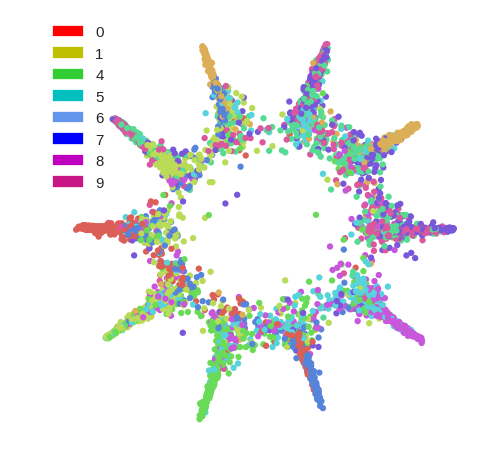

In [16]:
##Bottleneck layer codes visualization
y = F_enc(x_train_noisy[:6000])
_ = embedding2dplot(y, y_train[:6000], show_median=False)
import matplotlib.patches as mpatches
plt.axis('on')
#plt.legend()
plt.xlim(-15, 15)
plt.ylim(-15, 15)
zero_patch = mpatches.Patch(color='red', label='0')
one_patch = mpatches.Patch(color='y', label='1')
second_patch = mpatches.Patch(color='yellowgreen', label='2')
third_patch = mpatches.Patch(color='lawngreen', label='3')
four_patch = mpatches.Patch(color='limegreen', label='4')
five_patch = mpatches.Patch(color='c', label='5')
six_patch = mpatches.Patch(color='cornflowerblue', label='6')
seven_patch = mpatches.Patch(color='b', label='7')
eight_patch = mpatches.Patch(color='m', label='8')
nine_patch = mpatches.Patch(color='mediumvioletred', label='9')
plt.legend(handles=[zero_patch,one_patch,four_patch,five_patch,six_patch,seven_patch,eight_patch,nine_patch])